Submission Deadline: __October 20, 2023; 11:59 PM__

A penalty will be applied for late submission. Please refer to the course policy for more detail.  

## Instructions

Please read the instructions carefully before you start working on the homework.

- Please follow instructions and printed out the results as required. Keep the printed results and your implementation for grading purpose.
    - The TAs will not run your code for grading purpose unless it is necessary. That means, you may lose some points if the printed results are not in the submitted file.
- Submission should be via Canvas.
    - If you use Google Colab for running the code, please download the file and submit it via Canvas once it's done.
    - Submission via a Google Colab link will be considered as an invalid submission.
- Please double check the submitted file once you upload it to Canvas.
    - Students should be responsible for checking whether they submit the right files.
    - Re-submission is not allowed once the deadline is passed.

Also, if you missed the class lectures, please study the course materials first before working on the homework. It may save you some time.

# Homework 02 Word Embeddings

### Goal

The **goal** of this homework is to provide an opportunity to build an end-to-end system.

Specifically, we are going to build a word embedding system, that can

1. Read and preprocess raw data
2. Use two different ways (latent semantic analysis and skip-gram) to learn word embeddings
3. Evaluate the quality of word embeddings using some intrinsic evaluation methods

### Submission

Your submission should only include this notebook file. Please keep **all the outputs** in your submission for grading. We will run the code only if we are not sure it is correct.

### Dependency

You will need the following package to finish this homework assignment

- [spaCy](https://pypi.org/project/spacy/)
- [fasttext](https://pypi.org/project/fasttext/)

### Hint

Search for the keyword `TODO` to find out which parts need your input

In [1]:
# Download the data from course webpage
import urllib.request
from os.path import isfile
if not isfile("embeddings/imdb-small.txt"):
    url = "https://yangfengji.net/uva-nlp-grad/data/embeddings.zip"
    print("Downloading ...")
    filename, headers = urllib.request.urlretrieve(url, filename="embeddings.zip")

    print("Decompressing the file ...")
    !unzip embeddings.zip

sents = open("embeddings/imdb-small.txt").read().split("\n")
print("Read {} sentences".format(len(sents)))

Decompressing the file ...
Archive:  embeddings.zip
   creating: embeddings/
  inflating: embeddings/imdb-small.txt  
  inflating: embeddings/word-pairs.txt  
Read 10000 sentences


## 1. Data Processing (5 points)

Data processing is an **essential** skill for NLP researchers. Unlike machine learning where researchers sometimes may want to use synthetic data to demonstrate the potential of their algorithms, NLP researchers need to deal with real-world data all the time. Unfortunately, this means that these data are noisy and often contain irregular patterns. Therefore, a reasonable data processing can alleviate the challenge of building NLP systems to some extent and may also help boost the performance of machine learning models.

Data processing for learning word embeddings includes two basic modules

- Tokenizing texts and replacing some special tokens
- Filtering low-frequency and building a vocab

### 1.1 Tokenization (2 points)

The following function *tokenize()* should include the following components

1. Load the raw text from the file named **imdb-small.txt**
2. Convert all characters into lower cases
3. Tokenize the raw text using `nltk.tokenize`
4. Remove all punctuation (as single tokens) and replace all numbers with a special token `<num>`
5. Write the preprocessed text to the file named **imdb-small.txt.tokenized** and maintain the same format (one paragraph per line)

(The file names are pre-defined, please do not change them.)

In [2]:
# TODO: add necessary packages here
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer


def tokenize(infname="embeddings/imdb-small.txt"):
    outfname = open(infname + ".tokenized", "w")

    # ----------------------------------------
    # TODO: add your code here
    # convert all characters to lower case
    with open(infname, "r") as file:
      # tokenize the raw text via nltk.tokenize
      nltk.download("punkt")
      # remove punctuation as single tokens
      tokenizer = RegexpTokenizer(r'\w+')

      # we can do it this way
      for line in file:
        line = line.lower()
        line_tokens = []
        tokens = word_tokenize(line)
        for token in tokens:
          if token.isnumeric():
            line_tokens.append("<num>")
          else:
            line_tokens.extend(tokenizer.tokenize(token))

      # or we can do it this way:
      # for line in file:
      #     line = line.lower()
      #     line_tokens = []
      #     tokens = word_tokenize(line)
      #     for token in tokens:
      #       line_tokens.extend(tokenizer.tokenize(token))

      #     line_tokens = ["<num>" if item.isnumeric() else item for item in line_tokens]


        cleaned_text = " ".join(line_tokens)
        outfname.write("{}\n".format(cleaned_text))

    # ----------------------------------------
    outfname.close()

### 1.2 Filtering (2 points)

The following function *token_filter()* should include the following components

1. Remove the words that appear in the data less than 5 times (word_frequency < 5)
2. Write the filtered data to the file named **imdb-small.txt.filtered** and maintain the same format (one sentence per line)
3. Return a Python list that contains all the words

Slight issue: the token <num> is converted into < num >

In [3]:
# TODO: add necessary packages here
from nltk.probability import FreqDist
from collections import Counter

def token_filter(infname="embeddings/imdb-small.txt.tokenized", thresh=5):
    outfname = open(infname.replace(".tokenized", ".filtered"), 'w')
    # vocab = []

    # ----------------------------------------
    # TODO: remove "pass" and add your code here
    # remove words that appear less than 5 times
    with open(infname, "r") as file:
      content = file.read()

      # print(tokens)
      word_freq = Counter(content.split(" "))
      common_words = [word for word in word_freq if word_freq[word] >= thresh]
      print(common_words[0:10])

    with open(infname, "r") as file:
      for line in file:
        # line_tokens = word_tokenize(line)
        filtered_tokens = [word for word in line.split(" ") if word_freq[word] >= thresh]
        cleaned_line = " ".join(filtered_tokens)
        outfname.write("{}\n".format(cleaned_line))

    # return a python list with all the words

    # ----------------------------------------
    outfname.close()
    # return vocab
    return common_words

### 1.3 Put all together (1 point)

The following code block will call the previous two functions to do data preprocessing.

This code block should include the following steps

- tokenization
- build the vocabulary with the variable name `vocab`
- print out the size of the vocabulary

In [4]:
tokenize()
vocab = token_filter()
print("The vocab size = {}".format(len(vocab)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching']
The vocab size = 18445


## 2. Word Embeddings (5 points)

In this section, you need to implement two different ways of constructing word embeddings: latent semantic analysis  and skipgram.

### 2.1 Latent semantic analysis (3 points)

The function of LSA should include the following components

- Construct the word-doc matrix using `CountVectorizer` with `tokenizer=lambda x : x.split()`, make sure in this matrix that each row represents one word and each column represents one document (sentence, to be accurate in this case)
- Use the `TruncatedSVD` from `sklearn.decomposition` to factorize the word-doc matrix
- Construct the word embedding matrix with dimensionality as $v \times k$, where $v$ is the vocab size and $k$ is the word embedding dimension

The LSA() function should return

- **embeddings**: A matrix with size $v\times k$ that contains all the word embeddings
- **vocab**: A Python dict with size $v$ that maps a word to the corresponding word index. Please pay attention to the mapping relation in vocab, which will be needed in the evaluation section.

In [5]:
# TODO: add necessary packages here
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

def LSA(fname = "embeddings/imdb-small.txt.filtered", dim=50):
    sents = open(fname).read().split("\n")

    # -------------------------------------
    # TODO: add your code here
    # construct the word-doc matrix using CountVectorizer with tokenizer=lambda x : x.split()
    # ensure that in this matrix, ecah row represents a word and each col represents a doc (sentence)
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split())

    # okay so vectorizer.vocabulary_ gives us the mapping from word to matrix index
    # and fit_transform gets us the matrix
    embeddings = vectorizer.fit_transform(sents)
    # print(vectorizer.get_feature_names_out()[0:20])
    print(embeddings.shape)
    # need to transpose embeddings so that we can get the words on rows and setnences in columns. Currently, the columns are words and rows are sentences
    embeddings = embeddings.T
    print(embeddings.shape)

    svd = TruncatedSVD(n_components=dim)


    # construct the word embedding matrix with dim v x k where v is vocab size nad k is word embedding dim
    embeddings = svd.fit_transform(embeddings)
    vocab = vectorizer.vocabulary_

    # -------------------------------------
    return embeddings, vocab

### 2.2 Skip-gram model (2 points)

In this section, you do not have to implement the skip-gram model by yourself. An authentic implementation of skip-gram can be found in the Python package [fasttext](https://pypi.org/project/fasttext/), which you can install on the your local machine with the folllwing commandline or directly load the package if you are using Google Colab.
```python
pip install fasttext
```

In the following code, please use the `fasttext.train_unsupervised` function for the skipgram() implementation. For the `fasttext.train_unsupervised`, please use the following configurations

- `model='skipgram'`
- Context window size: `ws = 3`
- Word embedding dimension: `dim = 50`
- Number of negative examples: `neg = 5`

For all other parameters, use their default values.

Similar to the previous LSA(), Skipgram() should return

- **embeddings**: A matrix with size $v\times k$ that contains all the word embeddings
- **vocab**: A Python dict with size $v$ that maps an index to the corresponding word

To get the word embeddings and vocab from fasttext, you need to understand [some functions](https://pypi.org/project/fasttext/#api) provided by the `model` object in the fasttext.

In [6]:
import sys
if "fasttext" in sys.modules:
  print("installed")
else:
  !pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199771 sha256=a8d85a90fe56a5df93749819f568dfe5b6aa673711e6ab9ca327aaf06a775e0e
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [7]:
# # TODO: add necessary packages here
# import fasttext

# def Skipgram(fname = "embeddings/imdb-small.txt.filtered", ws=3, dim=50):
#     # ------------------------------------------
#     # TODO: add your code here
#     model = fasttext.train_unsupervised(fname, model='skipgram', ws=ws, dim=dim, neg=5)
#     # print(model.get_dimension)
#     embeddings = model.get_input_matrix()


#     # getting vocab
#     words = model.get_words()

#     vocab = {}

#     for word in words:
#       vocab[word] = model.get_word_id(word)
#     # vocab = model.get_words()

#     # ------------------------------------------
#     return embeddings, vocab

In [8]:
# TODO: add necessary packages here
import fasttext

def Skipgram(fname = "embeddings/imdb-small.txt.filtered", ws=3, dim=50):
    # ------------------------------------------
    # TODO: add your code here
    model = fasttext.train_unsupervised(fname, model='skipgram', ws=ws, dim=dim, neg=5)

    # getting vocab
    words = model.get_words()
    vocab = {}
    embeddings = [None] * len(words)

    for word in words:
      embeddings[model.get_word_id(word)] = model.get_word_vector(word)
      vocab[word] = model.get_word_id(word)

    # ------------------------------------------
    return embeddings, vocab

### 2.3 Put all together

Run the following code blocks to get word embeddings from two different methods. It may take a couple of minutes to compute both embeddings.

In [9]:
embeddings_lsa, vocab_lsa = LSA()
embeddings_sg, vocab_sg = Skipgram()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(10000, 18312)
(18312, 10000)


The following code will serve as the sanity check that `vocab_lsa` and `vocab_sg` contain the same words

In [10]:
lsa_word_set = set([item[0] for item in vocab_lsa.items()])
sg_word_set = set([item[0] for item in vocab_sg.items()])
sym_diff = lsa_word_set.symmetric_difference(sg_word_set)

if len(sym_diff) == 0:
    print("vocab_lsa and vocab_sg contain the same words!")
else:
    print("The word that only appear in one vocab: {}".format(sym_diff))

The word that only appear in one vocab: {'</s>'}


If the only word from the `symmetric_difference()` function is `</s>`, then your implementation should be fine. (`</s>` was added by `fasttext` automatically to the end of each text.)

## 3. Evaluation (5 points)

In this homework, we will only use intrinsic evaluation. Specifically, for a list of predefined word pairs with their similarity scores, the evaluation is to calculate the correlation between the predefined similarity scores and the cosine similarity scores based on word embeddings. The higher the correlation, the better the quality of word embeddings.

In [11]:
def load_wordpairs(fname = "embeddings/word-pairs.txt", vocab=vocab):
    records = {}
    with open(fname) as fin:
        for line in fin:
            items = line.strip().split(",")
            if (items[1] in vocab) and (items[2] in vocab): # make sure both words in the vocab
                records[(items[1],items[2])] = float(items[3])
    print("Load {} pairs of words for evaluation".format(len(records)))
    return records

### 3.1 Word similarity correlation (2 points)

The purpose of this section is to implement the correlation function that compares the predefined scores and the scores computed by cosine similarity. The code of the correlation function is almost done, and the only thing left is the code for computing cosine similarity.

In [12]:
from scipy.stats import pearsonr
# TODO: Add necessary packages here
from numpy import dot
from numpy.linalg import norm

def correlation(records, embeddings, vocab):
    predefined_scores = []
    cossim_scores = []
    for (words, sim_score) in records.items():
        predefined_scores.append(sim_score)
        # ---------------------------------
        # TODO: add your code here for computing the cossine similarity
        #       between words[0] and words[1], and assign the value to variable "score"
        v1 = embeddings[vocab[words[0]]]
        v2 = embeddings[vocab[words[1]]]
        score = dot(v1, v2)/(norm(v1) * norm(v2))
        cossim_scores.append(score)
        # ---------------------------------
    corr = pearsonr(predefined_scores, cossim_scores)
    return corr

Run the following code block to calculate the correlations between pre-defined similarity scores and the cosine similarity scores based on word embeddings

In [13]:
# assuming we need to populate records here:
records = load_wordpairs()

corr_lsa = correlation(records, embeddings_lsa, vocab_lsa)
print("The correlation with the LSA embeddings = {} with p-value {}".format(corr_lsa[0], corr_lsa[1]))
corr_sg = correlation(records, embeddings_sg, vocab_sg)
print("The correlation with the SG embeddings = {} with p-value {}".format(corr_sg[0], corr_sg[1]))

if corr_lsa[0] > corr_sg[0]:
    print("LSA is better than Skip-gram")
elif corr_lsa[0] < corr_sg[0]:
    print("Skipgram is better than LSA")

Load 147 pairs of words for evaluation
The correlation with the LSA embeddings = 0.17513518696789473 with p-value 0.03386286673335794
The correlation with the SG embeddings = 0.3353329502546251 with p-value 3.2979695853904775e-05
Skipgram is better than LSA


### 3.2 Analysis of context window size in Skipgram (3 points)

With the correlation function, we can analyze the effect of different context window sizes in the Skipgram model. Specifically, please call the previous implementation

- `Skipgram(fname, ws, dim=50)` with the context window size `ws` as 3, 6, 9, 12, 15
- For each context window size, calculate the correlation using the function `correlation(records, embeddings, vocab)`
- **Print out** the fives correlation scores in your final submission: one score per line with the following format
<center> ws\t correlation</center>

In [14]:
# TODO: add your code here
wsizes = [3, 6, 9, 12, 15]
correlations = []

for ws in wsizes:
  embeddings_sg, vocab_sg = Skipgram(ws=ws)
  corr_sg = correlation(records, embeddings_sg, vocab_sg)
  correlations.append(corr_sg)
  print("{}\t{}".format(ws, corr_sg))

3	PearsonRResult(statistic=0.3353329502546251, pvalue=3.2979695853904775e-05)
6	PearsonRResult(statistic=0.35810578905237, pvalue=8.454613381787837e-06)
9	PearsonRResult(statistic=0.3521101124495204, pvalue=1.2223608204379404e-05)
12	PearsonRResult(statistic=0.3709323959282852, pvalue=3.745798854434258e-06)
15	PearsonRResult(statistic=0.4119353529025369, pvalue=2.173413630854652e-07)


Similar experiment can also be conducted on the parameter of negative examples `neg`, but it will not be included in this homework.

In [15]:
print(wsizes)

[3, 6, 9, 12, 15]


In [16]:
print(correlations)

[PearsonRResult(statistic=0.3353329502546251, pvalue=3.2979695853904775e-05), PearsonRResult(statistic=0.35810578905237, pvalue=8.454613381787837e-06), PearsonRResult(statistic=0.3521101124495204, pvalue=1.2223608204379404e-05), PearsonRResult(statistic=0.3709323959282852, pvalue=3.745798854434258e-06), PearsonRResult(statistic=0.4119353529025369, pvalue=2.173413630854652e-07)]


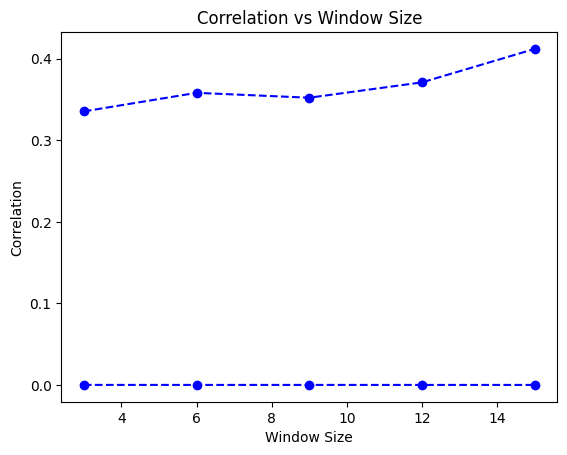

In [17]:
import matplotlib.pyplot as plt

plt.plot(wsizes, correlations, marker='o', linestyle='--', color='b')
plt.xlabel('Window Size')
plt.ylabel('Correlation')
plt.title('Correlation vs Window Size')

plt.show()